In [4]:
import numpy as np
import scipy as sp
from scipy.integrate import ode
import matplotlib.pyplot as plt
import time
import random
import pandas as pd
import statsmodels.api as sm
from sklearn import datasets, linear_model
%matplotlib inline

In [5]:
kB = 1.38e-23 # [m^2 kg s^-2 K^-1]
m = 7 * 1.66e-27 # [kg]
C6 = 1394 # C6 for Li+Li
De = 334 # De for Li+Li 
C12 = C6**2/(4*De) # C12 coefficient given atom-atom depth De

def VLJ(r):
    '''Lennard-Jones potential for a pair of atoms separated by distance r.'''
    return C12/r**12 - C6/r**6

def Vtot(r1,r2,r3):
    '''Total potential energy for all three atoms'''
    r12 = np.linalg.norm(r1-r2)
    r23 = np.linalg.norm(r2-r3)
    r13 = np.linalg.norm(r1-r3)
    return VLJ(r12) + VLJ(r23) + VLJ(r13)

def dVdr(rA,rB,rC):
    '''form of derivative of V for particle A interacting with B and C'''
    rAB = rA - rB
    rAC = rA - rC
    rABnorm = np.linalg.norm(rAB)
    rACnorm = np.linalg.norm(rAC)
    if (rABnorm>0 and rACnorm>0):
        deriv_x = (12*C12*rAB[0])/rABnorm**14 - (6*C6*rAB[0])/rABnorm**8 + \
                  (12*C12*rAC[0])/rACnorm**14 - (6*C6*rAC[0])/rACnorm**8
        deriv_y = (12*C12*rAB[1])/rABnorm**14 - (6*C6*rAB[1])/rABnorm**8 + \
                  (12*C12*rAC[1])/rACnorm**14 - (6*C6*rAC[1])/rACnorm**8
        deriv_z = (12*C12*rAB[2])/rABnorm**14 - (6*C6*rAB[2])/rABnorm**8 + \
                  (12*C12*rAC[2])/rACnorm**14 - (6*C6*rAC[2])/rACnorm**8
    else:
        deriv_x = 1000 * np.ones(3)
        deriv_y = 1000 * np.ones(3)
        deriv_z = 1000 * np.ones(3)
        
    return np.array([deriv_x, deriv_y, deriv_z])

In [6]:
# rhs of ODE
def f_ODE(t, s):
    r1 = s[0:3]
    r2 = s[3:6]
    r3 = s[6:9]
    v1 = s[9:12]
    v2 = s[12:15]
    v3 = s[15:18]
    
    dV1 = dVdr(r1,r2,r3)
    dV2 = dVdr(r2,r1,r3)
    dV3 = dVdr(r3,r1,r2)
    
    output = np.array([v1,v2,v3,dV1,dV2,dV3]).flatten()
    return output

def run_collision(T, theta = np.pi/2, b = 0, t=(0, 100), dt = 0.01, rinit1 = 60.0, max_step = 0.1):
    ''' 
    Runs colision simulation and returns scattering time, as well as vectors of atoms' positions.
    
    Parameters
    ----------
    T : float
        The temperature of the incoming atom, setting the the collision energy
    theta : float
        The angle of the molecule (Defaults to Pi/2, so molecule is perpendicular to atom's initial trajectory)
    b : float
        The impact parameter of the collision (Defaults to zero)
    t : float tuple (t0, t1)
        The initial and final time of the intergation (Defaults to (0, 100))
    dt : float
        The time step of integration (Defaults to 0.01)
    rinit1: float
        The initial position of the atom (Defaults to 60.0)
    
    '''
    # initial time and end time
    t0, t1 = t
    ## initial positions of atoms
    # distance between dimer's atoms
    d_molec = 1.1
    r0 = np.array([[-rinit1/3, 0, 0],
               [rinit1/6+d_molec*np.cos(theta)/2, -d_molec*np.sin(theta)/2, 0],
               [rinit1/6-d_molec*np.cos(theta)/2,d_molec*np.sin(theta)/2,0]])

    # initial velocities of each atom
    vinit = -np.sqrt(kB*T/m)/10 # in nm/ns
    v0 = np.array([[-vinit,0,0],
                   [0,0,0],
                   [0,0,0]])
    # group into vector  of ICs
    s0 = np.array([r0,v0])
    s0 = s0.flatten()
    
    # set up integrator
    r = ode(f_ODE).set_integrator('dop853', max_step = max_step)
    r.set_initial_value(s0, t0)

    # position vectors
    x1out = np.zeros(int(np.ceil(t1/dt)))
    y1out = np.zeros(int(np.ceil(t1/dt)))
    z1out = np.zeros(int(np.ceil(t1/dt)))
    x2out = np.zeros(int(np.ceil(t1/dt)))
    y2out = np.zeros(int(np.ceil(t1/dt)))
    z2out = np.zeros(int(np.ceil(t1/dt)))
    x3out = np.zeros(int(np.ceil(t1/dt)))
    y3out = np.zeros(int(np.ceil(t1/dt)))
    z3out = np.zeros(int(np.ceil(t1/dt)))
    n = 0
    hyperrad = rinit1/2
        
    while hyperrad < rinit1 and r.t < t1:
        ds = r.integrate(r.t+dt)
        x1out[n] = ds[0] + vinit* r.t /3
        y1out[n] = ds[1]
        z1out[n] = ds[2]
        x2out[n] = ds[3] + vinit* r.t /3
        y2out[n] = ds[4]
        z2out[n] = ds[5]
        x3out[n] = ds[6] + vinit* r.t /3
        y3out[n] = ds[7]
        z3out[n] = ds[8]
        hyperrad = np.sqrt(np.sum(ds[0:9]**2))
        n+=1
        
    x1out = x1out[0:n]
    y1out = y1out[0:n]
    z1out = z1out[0:n]
    x2out = x2out[0:n]
    y2out = y2out[0:n]
    z2out = z2out[0:n]
    x3out = x3out[0:n]
    y3out = y3out[0:n]
    z3out = z3out[0:n]
    
    # check which of the three atoms emerges independently
    r1_final = np.array([x1out[-1], y1out[-1], z1out[-1]])
    r2_final = np.array([x2out[-1], y2out[-1], z2out[-1]])
    r3_final = np.array([x3out[-1], y3out[-1], z3out[-1]])
    r12 = np.sqrt(np.sum((r1_final-r2_final)**2))
    r13 = np.sqrt(np.sum((r1_final-r3_final)**2))
    r23 = np.sqrt(np.sum((r3_final-r2_final)**2))
    
    #print("r12 %0.2f, r13 %0.2f, r23 %0.2f" %(r12, r13, r23))
    basin = 0 # the three atoms emerge separately
    if r12<2: basin=1
    elif r13<2: basin=2
    else: basin=3
        
    return [r.t, basin, x1out, y1out, z1out, x2out, y2out, z2out, x3out, y3out, z3out]

(-7, 7)

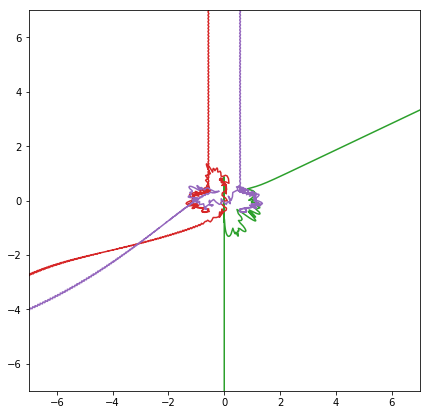

In [7]:
# Example of collision
x1out, y1out, z1out, x2out, y2out, z2out, x3out, y3out, z3out = run_collision(T=10, dt = 0.01, theta = np.pi/2)[2:]
plt.figure(figsize=(7,7))
plt.plot(y1out,x1out,'C2')
plt.plot(y2out,x2out,'C3')
plt.plot(y3out,x3out,'C4')
plt.xlim(-7,7)
plt.ylim(-7,7)

# Lifetime as a function of collision energy

In [28]:
# Use run_tests to only run simulations when making an update on the data (to avoid having to wait every time)
run_tests = 0
Tlist = [0.1, 0.25, 0.5, 0.75, 1, 2, 5, 7.5, 10, 20, 40, 50, 75, 100]
#Tlist = [0.1, 0.5, 1, 10, 20,50, 100]
if run_tests:
    tlist = []
    for T in Tlist:
        tlist = np.append(tlist, run_collision(T)[0]) 
else:
    tlist = np.array([58.56, 60.26, 41.18, 33.52, 26.68, 17.62, 10.45, 10.55, 9.48, 6.4 , 4.64, 3.54, 2.87, 2.49])

In [29]:
# Fit power law

fitfunc = lambda p, x: p[1]*x**(p[0]) # Target function
errfunc = lambda p, x, y: fitfunc(p, x) - y # Distance to the target function
p0 = [-1, 1] # Initial guess for the parameters
p1, success = sp.optimize.leastsq(errfunc, p0[:], args=(Tlist, tlist))
p1

array([ -0.39406209,  27.4105922 ])

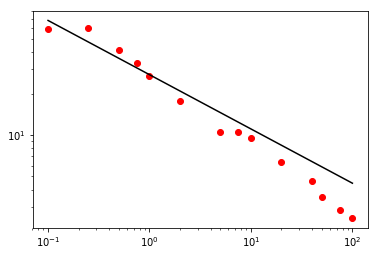

In [30]:
# Plot lifetime and fitted power law

Tpowerlaw = np.linspace(0.1,100,20)
plt.loglog(Tlist,tlist,'ro')
plt.loglog(Tpowerlaw,fitfunc(p1, Tpowerlaw),'k')

# Varying step size and delta_t size

C:\Users\AndreiHoria\Anaconda3\lib\site-packages\scipy\integrate\_ode.py:1035: UserWarning: dop853: larger nmax is needed
  self.messages.get(idid, 'Unexpected idid=%s' % idid))


(-7, 7)

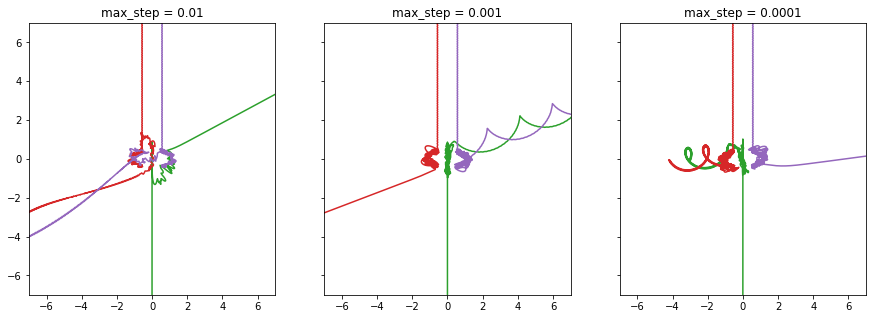

In [131]:
# Example of effect of max step size
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(15,5)

x1out, y1out, z1out, x2out, y2out, z2out, x3out, y3out, z3out = run_collision(T=10, theta = np.pi/2, max_step = 0.01)[2:]
ax1.set_title("max_step = 0.01")
ax1.plot(y1out,x1out,'C2')
ax1.plot(y2out,x2out,'C3')
ax1.plot(y3out,x3out,'C4')
ax1.set_xlim(-7,7)
ax1.set_ylim(-7,7)

x1out, y1out, z1out, x2out, y2out, z2out, x3out, y3out, z3out = run_collision(T=10, theta = np.pi/2, max_step = 0.001)[2:]
ax2.set_title("max_step = 0.001")
ax2.plot(y1out,x1out,'C2')
ax2.plot(y2out,x2out,'C3')
ax2.plot(y3out,x3out,'C4')
ax2.set_xlim(-7,7)
ax2.set_ylim(-7,7)

x1out, y1out, z1out, x2out, y2out, z2out, x3out, y3out, z3out = run_collision(T=10, theta = np.pi/2, max_step = 0.00001)[2:]
ax3.set_title("max_step = 0.0001")
ax3.plot(y1out,x1out,'C2')
ax3.plot(y2out,x2out,'C3')
ax3.plot(y3out,x3out,'C4')
ax3.set_xlim(-7,7)
ax3.set_ylim(-7,7)

For bigger step sizes we get fundamentally different results. For $max\_step = 0.01$ we get A + BC, for $max\_step = 0.001$ we get AC+B, while for $$ max\-step = 0.00001$ we get AB+C.

The same is true if we vary d_t.

(-7, 7)

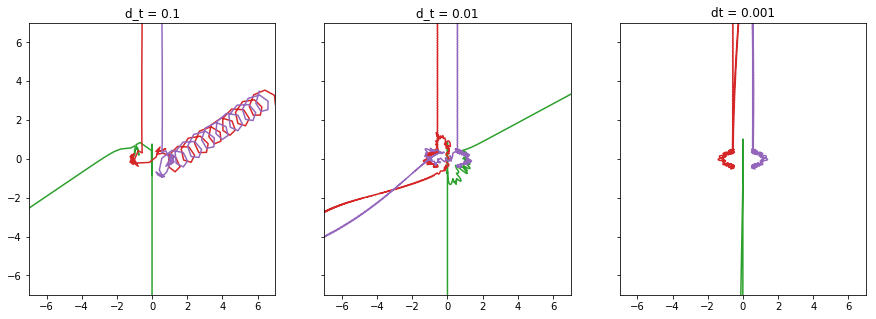

In [193]:
# Example of effect of max step size
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(15,5)

x1out, y1out, z1out, x2out, y2out, z2out, x3out, y3out, z3out = run_collision(T=10, theta = np.pi/2, dt = 0.1)[2:]
ax1.set_title("d_t = 0.1")
ax1.plot(y1out,x1out,'C2')
ax1.plot(y2out,x2out,'C3')
ax1.plot(y3out,x3out,'C4')
ax1.set_xlim(-7,7)
ax1.set_ylim(-7,7)

x1out, y1out, z1out, x2out, y2out, z2out, x3out, y3out, z3out = run_collision(T=10, theta = np.pi/2, dt = 0.01)[2:]
ax2.set_title("d_t = 0.01")
ax2.plot(y1out,x1out,'C2')
ax2.plot(y2out,x2out,'C3')
ax2.plot(y3out,x3out,'C4')
ax2.set_xlim(-7,7)
ax2.set_ylim(-7,7)

x1out, y1out, z1out, x2out, y2out, z2out, x3out, y3out, z3out = run_collision(T=10, theta = np.pi/2, dt = 0.001)[2:]
ax3.set_title("dt = 0.001")
ax3.plot(y1out,x1out,'C2')
ax3.plot(y2out,x2out,'C3')
ax3.plot(y3out,x3out,'C4')
ax3.set_xlim(-7,7)
ax3.set_ylim(-7,7)

# Chaos: function of impact angle $\theta$

r12 38.14, r13 38.14, r23 40.99
r12 22.24, r13 42.28, r23 46.40
r12 38.46, r13 29.02, r23 47.12


(-7, 7)

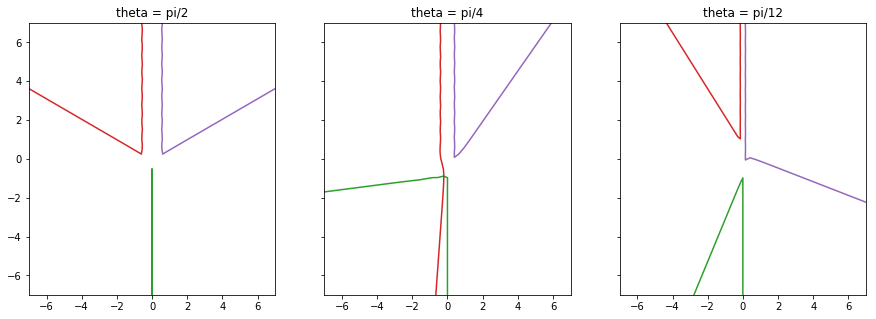

In [150]:
# Example of effect of mlecule orientation
T = 500

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(15,5)

x1out, y1out, z1out, x2out, y2out, z2out, x3out, y3out, z3out = run_collision(T=T, theta = np.pi/2)[2:]
ax1.set_title("theta = pi/2")
ax1.plot(y1out,x1out,'C2')
ax1.plot(y2out,x2out,'C3')
ax1.plot(y3out,x3out,'C4')
ax1.set_xlim([-7,7])
ax1.set_ylim([-7,7])

x1out, y1out, z1out, x2out, y2out, z2out, x3out, y3out, z3out = run_collision(T=T, theta = np.pi/4)[2:]
ax2.set_title("theta = pi/4")
ax2.plot(y1out,x1out,'C2')
ax2.plot(y2out,x2out,'C3')
ax2.plot(y3out,x3out,'C4')
ax2.set_xlim([-7,7])
ax2.set_ylim([-7,7])

x1out, y1out, z1out, x2out, y2out, z2out, x3out, y3out, z3out = run_collision(T=T, theta = np.pi/12)[2:]
ax3.set_title("theta = pi/12")
ax3.plot(y1out,x1out,'C2')
ax3.plot(y2out,x2out,'C3')
ax3.plot(y3out,x3out,'C4')
ax3.set_xlim([-7,7])
ax3.set_ylim([-7,7])

### Lifetime as a function of initial orientation of moelcule, given by $\theta$.

For N = 1000, T = 25 K.

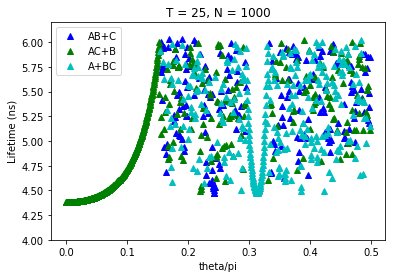

In [15]:
# Run simlulation
run_simulation = 0
N_theta = 1000
theta_i = 0
theta_f = np.pi/2
theta = np.linspace(theta_i, theta_f, N_theta)

if run_simulation:
    t = time.time()
    T = 25
    basin=0;
    collison = np.zeros(11)

    theta_lifetime = np.zeros((4, N_theta))
    theta_basins_N = np.zeros(4, dtype=int)
    theta_theta = np.zeros((4, N_theta))

    for i in range(N_theta):
        collison = run_collision(T=T, theta=theta[i])
        basin = collison[1]
        theta_basins_N[basin] += 1
        theta_lifetime[basin][theta_basins_N[basin]] = collison[0]
        theta_theta[basin][theta_basins_N[basin]] = theta[i]
    
    elapsed_time = time.time() - t
    print("Running simulation took %0.2f seconds" %(elapsed_time))
    
# Plot results
legend_str=[]
if not len(theta_lifetime[0][:theta_basins_N[0]])==0: 
    plt.plot(theta_theta[0][0:theta_basins_N[0]]/np.pi, theta_lifetime[0][0:theta_basins_N[0]],  'r^')
    legend_str.append("A+B+C")
if not len(theta_lifetime[1][:theta_basins_N[1]])==0:
    plt.plot(theta_theta[1][0:theta_basins_N[1]]/np.pi, theta_lifetime[1][0:theta_basins_N[1]],  'b^')
    legend_str.append("AB+C")
if not len(theta_lifetime[2][:theta_basins_N[2]])==0:
    plt.plot(theta_theta[2][0:theta_basins_N[2]]/np.pi, theta_lifetime[2][0:theta_basins_N[2]],  'g^')
    legend_str.append("AC+B")  
if not len(theta_lifetime[3][:theta_basins_N[3]])==0: 
    plt.plot(theta_theta[3][0:theta_basins_N[3]]/np.pi, theta_lifetime[3][0:theta_basins_N[3]],  'c^')
    legend_str.append("A+BC")
plt.xlabel("theta/pi")
plt.ylabel("Lifetime (ns)")
plt.title("T = %s, N = %s" %(T, N_theta))
plt.legend(legend_str)
plt.ylim([4,6.2])
plt.show()

### Zooming in:

For N = 1000, T = 25 K:

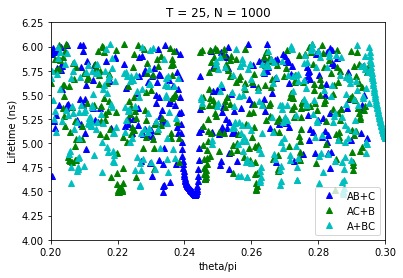

In [19]:
# Run simlulation
run_simulation = 0
N_theta = 1000
theta_i = 0.2*np.pi
theta_f = 0.3*np.pi
theta = np.linspace(theta_i, theta_f, N_theta)

if run_simulation:
    t = time.time()
    T = 25
    basin=0;
    collison = np.zeros(11)

    theta_lifetime = np.zeros((4, N_theta))
    theta_basins_N = np.zeros(4, dtype=int)
    theta_theta = np.zeros((4, N_theta))

    for i in range(N_theta):
        collison = run_collision(T=T, theta=theta[i])
        basin = collison[1]
        theta_basins_N[basin] += 1
        theta_lifetime[basin][theta_basins_N[basin]] = collison[0]
        theta_theta[basin][theta_basins_N[basin]] = theta[i]
    
    elapsed_time = time.time() - t
    print("Running simulation took %0.2f seconds" %(elapsed_time))
    
# Plot results
legend_str=[]
if not len(theta_lifetime[0][:theta_basins_N[0]])==0: 
    plt.plot(theta_theta[0][0:theta_basins_N[0]]/np.pi, theta_lifetime[0][0:theta_basins_N[0]],  'r^')
    legend_str.append("A+B+C")
if not len(theta_lifetime[1][:theta_basins_N[1]])==0:
    plt.plot(theta_theta[1][0:theta_basins_N[1]]/np.pi, theta_lifetime[1][0:theta_basins_N[1]],  'b^')
    legend_str.append("AB+C")
if not len(theta_lifetime[2][:theta_basins_N[2]])==0:
    plt.plot(theta_theta[2][0:theta_basins_N[2]]/np.pi, theta_lifetime[2][0:theta_basins_N[2]],  'g^')
    legend_str.append("AC+B")  
if not len(theta_lifetime[3][:theta_basins_N[3]])==0: 
    plt.plot(theta_theta[3][0:theta_basins_N[3]]/np.pi, theta_lifetime[3][0:theta_basins_N[3]],  'c^')
    legend_str.append("A+BC")
plt.xlabel("theta/pi")
plt.ylabel("Lifetime (ns)")
plt.title("T = %s, N = %s" %(T, N_theta))
plt.legend(legend_str)
plt.ylim([4,6.25])
plt.xlim([0.2, 0.3])
plt.show()

# The uncertainty algorithm and the fractal dimension

(From the John Bohn paper)

In the uncertainty algorithm two trajectories are considered stable if two trajectories that only differ by a $\delta$ in their initial conditions end up in the same basin. We can run a large number of ranom initial conditions differing by $\delta$ and each time compute the fraction of unstable trajectories, denoted by $f(\delta)$. We can then further fit the uncertainty exponent $\alpha$ (see Fig. 6):

$$ f(\delta, E_{col} \propto \delta^{\alpha(E_{col})}. $$



In [21]:
def delta_collision(delta, T, theta):
    ''' 
    Runs two colision simulations with perturbation delta and returns whether or not the two trajectories 
    end up in the same basin.
    
    Parameters
    ----------
    delta :  perturbation of initial parameter (in our case just theta)
    
    '''
    
    collision_1 = run_collision(T, theta, dt = 0.1)
    colliison_2 = run_collision(T, theta+delta, dt = 0.1)
    
    basin_1 = collision_1[1]
    basin_2 = colliison_2[1]
    
    if basin_1 == basin_2:
        return True # stable trajectory under perturbation delta
    else:
        return False

def run_delta_collisions(N, delta, T, theta_range):
    ''' 
    Runs N sets of colision simulations that differ by perturbation delta and returns the fraction that are stable
    
    Parameters
    ----------
    delta :  perturbation of initial parameter (in our case just theta)
    
    '''
    N_stable = 0
    for i in range(N):
        theta = random.uniform(theta_range[0], theta_range[1])
        if delta_collision(delta, T, theta):
            N_stable += 1
    
    return N_stable/N              
    

delta = [1.00000000e-12, 5.62341325e-10, 3.16227766e-07, 1.77827941e-04, 1.00000000e-01] <br>
<br>
--> T = 600, N = 2500 <br>
f = [1, 1, 1, 1, 0.8584] <br>
elap_times = [688.94694853, 699.27779841, 701.02508616, 701.66535497, 666.0059104] <br>
--> T = 450, N = 750 <br>
f = [1, 1, 1, 0.996, 0.80933333] <br>
elap_times = [467.16526246, 462.73323369, 453.20266843, 522.0183382, 422.0981493] <br>
--> T = 300, N = 1000 <br>
f = [0.999, 1, 1, 0.998, 0.814] <br>
elap_times = N/A <br>
--> T = 200, N = 2500 <br>
f = [0.9996, 0.9992, 1, 0.9952, 0.7164] <br>
elap_times = [1487.32410359, 1528.68231678, 1485.50739121, 1486.98902941, 1444.9302814] <br>
--> T = 100, N = 1000 <br>
f = [0.999, 0.998, 0.997, 0.979, 0.687] <br>
elap_times = [1167, 1349, 1525, 1223, 1211] <br>
--> T = 75, N =1000 <br>
f = [0.998, 0.992, 0.994, 0.957, 0.653] <br>
elap_times = [1633, 1628, 1563, 1649, 1565] <br>
--> T = 50, N = 1000 <br>
f = [0.959000, 0.968000, 0.960000, 0.871000, 0.627000] <br>
elap_times = [ 1971.945122, 2003.386422, 1977.850871, 1965.647397, 2004.759665] <br>
--> T = 25, N = 1000 <br>
f = [0.822, 0.806, 0.794, 0.697, 0.546] <br>
elap_times = [4170,  4181, 4180, 4325, 4362] <br>

In [33]:
df_stability = pd.DataFrame({'delta' : np.array( [1.00000000e-12, 5.62341325e-10, 3.16227766e-07, 1.77827941e-04, 1.00000000e-01] ),  
                            600 :  1-np.array([1, 1, 1, 1, 0.8584]),
                             450 : 1-np.array([1, 1, 1, 0.996, 0.80933333]),
                             300 : 1-np.array([0.999, 1, 1, 0.998, 0.814]),
                             200 : 1-np.array([0.9996, 0.9992, 1, 0.9952, 0.7164]),
                             100 : 1-np.array([0.999, 0.998, 0.997, 0.979, 0.687]),
                             75 : 1-np.array([0.998, 0.992, 0.994, 0.957, 0.653]),
                             50 : 1-np.array([0.959000, 0.968000, 0.960000, 0.871000, 0.627000]),
                            25 : 1-np.array([0.822, 0.806, 0.794, 0.697, 0.546])})

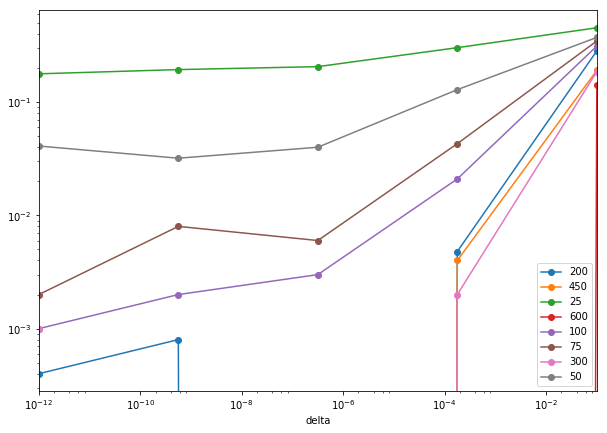

In [34]:
df_stability.plot(x='delta', y=list(df_stability.loc[:, df_stability.columns != 'delta']), \
                  figsize = (10,7), logy=True, logx=True, marker = 'o')

In [93]:
# x = df_stability[['delta']]
# pd.DataFrame(np.linalg.pinv(x.T.dot(x)).dot(x.T).dot(df_stability.fillna(0)),
#              ['Slope'], df_stability.columns)

fitfunc = lambda p, x: p[1]*np.power(x,(p[0])) # Target function
errfunc = lambda p, x, y: fitfunc(p, x) - y # Distance to the target function
p0 = [-1, 1] # Initial guess for the parameters

def fitdata(data_x, data_y):
    p1, success=sp.optimize.leastsq(errfunc,  p0[:], args=(data_x,data_y))
    return p1

fractal_dim = pd.DataFrame()
fractal_dim['Temp'] = df_stability.ix[:, (df_stability.columns != 'delta')].columns
frac_dim_list = np.zeros(fractal_dim.shape[0])
i = 0;
for temp in fractal_dim['Temp']:
    fit = fitdata(df_stability["delta"].values, df_stability[temp].values)[0]
    frac_dim_list[i] = (1-fit)
    i += 1
fractal_dim["Fractal_dim"] = pd.Series(frac_dim_list)  

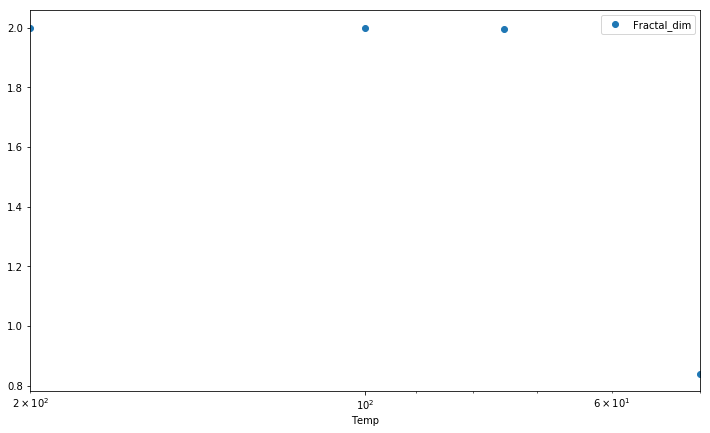

In [95]:
fractal_dim.plot(x='Temp', y='Fractal_dim', figsize = (12,7), logy=False, logx=True, style='o')